In [1]:
%cd open-images-v6/

/mnt/data/object_detection/open-images-v6


In [2]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
from tqdm import tqdm
import os
import glob
import re
import cv2
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
from detectron2.structures import BoxMode

In [3]:
def cv2_imshow(im):
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(16, 8))
    plt.imshow(im)
    plt.axis('off');

## 1. Download Open Images V6

Create a folder to save datasets:

In [ ]:
!mkdir -p open-images-v6
%cd open-images-v6

Download annotation files ([more details](https://storage.googleapis.com/openimages/web/download.html)):

In [ ]:
# train-annotations-bbox (2.10G)
!wget https://storage.googleapis.com/openimages/v6/oidv6-train-annotations-bbox.csv

# validation-annotations-bbox (23.94M)
!wget https://storage.googleapis.com/openimages/v5/validation-annotations-bbox.csv
    
# test-annotations-bbox (73.89M)
!wget https://storage.googleapis.com/openimages/v5/test-annotations-bbox.csv

# class-descriptions (448.58.73K)
!wget https://storage.googleapis.com/openimages/v6/oidv6-class-descriptions.csv

Obtain `downloadOI.py` from [learnopencv's tutorial](https://www.learnopencv.com/fast-image-downloader-for-open-images-v4/) to download specific classes:

In [ ]:
!wget https://raw.githubusercontent.com/spmallick/learnopencv/master/downloadOpenImages/downloadOI.py

Rename files to use `downloadOI.py`:

In [ ]:
!mv oidv6-class-descriptions.csv class-descriptions-boxable.csv
!mv oidv6-train-annotations-bbox.csv train-annotations-bbox.csv

All classes: [Flare Dendrogram](https://storage.googleapis.com/openimages/2018_04/bbox_labels_600_hierarchy_visualizer/circle.html)

In [4]:
# Class: 'Musical instrument'
target_classes = [
    'Accordion',
    'Banjo',
    'Cello',
    'Chime',
    'Drum',
    'Flute',
    'French horn',
    'Guitar',
    'Harmonica',
    'Harp',
    'Harpsichord',
    'Maracas',
    'Musical keyboard',
    'Oboe',
    'Organ (Musical Instrument)',
    'Piano',
    'Saxophone',
    'Trombone',
    'Trumpet',
    'Violin'
 ]

In [29]:
len(target_classes)

20

Download target classes:

In [46]:
# Download target classes
target_classes_str = ",".join(target_classes).replace(" ", "_")
!python3 downloadOI.py --classes 'Accordion,Banjo,Cello,Chime,Drum,Flute,French_horn,Guitar,Harmonica,Harp,Harpsichord,Maracas,Musical_keyboard,Oboe,Organ_(Musical_Instrument),Piano,Saxophone,Trombone,Trumpet,Violin' --mode train
!python3 downloadOI.py --classes 'Accordion,Banjo,Cello,Chime,Drum,Flute,French_horn,Guitar,Harmonica,Harp,Harpsichord,Maracas,Musical_keyboard,Oboe,Organ_(Musical_Instrument),Piano,Saxophone,Trombone,Trumpet,Violin' --mode validation

Class 0 : Accordion
Class 1 : Banjo
Class 2 : Cello
Class 3 : Chime
Class 4 : Drum
Class 5 : Flute
Class 6 : French_horn
Class 7 : Guitar
Class 8 : Harmonica
Class 9 : Harp
Class 10 : Harpsichord
Class 11 : Maracas
Class 12 : Musical_keyboard
Class 13 : Oboe
Class 14 : Organ_(Musical_Instrument)
Class 15 : Piano
Class 16 : Saxophone
Class 17 : Trombone
Class 18 : Trumpet
Class 19 : Violin
Annotation Count : 66310
Number of images to be downloaded : 29184
100%|█████████████████████████████████████| 29184/29184 [59:10<00:00,  8.22it/s]
Class 0 : Accordion
Class 1 : Banjo
Class 2 : Cello
Class 3 : Chime
Class 4 : Drum
Class 5 : Flute
Class 6 : French_horn
Class 7 : Guitar
Class 8 : Harmonica
Class 9 : Harp
Class 10 : Harpsichord
Class 11 : Maracas
Class 12 : Musical_keyboard
Class 13 : Oboe
Class 14 : Organ_(Musical_Instrument)
Class 15 : Piano
Class 16 : Saxophone
Class 17 : Trombone
Class 18 : Trumpet
Class 19 : Violin
Annotation Count : 798
Number of images to be downloaded : 441
100%|

## 2. Format annotations

### Create subset annotation dataframes

In [25]:
# Sort target_classes and create `class2id`
target_classes = [
    'Drum',
    'French horn',
    'Guitar',
    'Piano',
    'Saxophone',
    'Trumpet',
    'Violin'
 ]

target_classes = sorted(target_classes)
class2id = {class_: id_ for id_, class_ in enumerate(target_classes)}

In [26]:
# Get LabelName of target classes
classes = pd.read_csv("class-descriptions-boxable.csv", header=None, names=['LabelName', 'Class'])
subset_classes =classes[classes['Class'].isin(target_classes)]
subset_classes

,LabelName,Class
3663,/m/026t6,Drum
6730,/m/0319l,French horn
6878,/m/0342h,Guitar
11878,/m/05r5c,Piano
12958,/m/06ncr,Saxophone
13779,/m/07gql,Trumpet
14177,/m/07y_7,Violin


In [27]:
%%time
# Prepare annotation files
for folder in ['train', 'validation']:
    # Load data
    annot_df = pd.read_csv(f"{folder}-annotations-bbox.csv")
    # Merge to keep only target_classes
    annot_df = annot_df.merge(subset_classes, on='LabelName')
    # Create `ClassID` column
    annot_df['ClassID'] = annot_df['Class'].apply(lambda x: class2id[x])
    # Save truncated annot_df
    annot_df.to_csv(f"{folder}-annotations-bbox-target.csv", index=False)
    del annot_df

CPU times: user 23.9 s, sys: 3.62 s, total: 27.5 s
Wall time: 27.5 s


In [28]:
# Create a small train annotation file to run debugging
small_train = pd.read_csv("train-annotations-bbox-target.csv").sample(frac=0.1)
small_train.to_csv(f"small-train-annotations-bbox-target.csv", index=False)

### Explore data

In [17]:
target_train = pd.read_csv("train-annotations-bbox-target.csv")
target_val = pd.read_csv("validation-annotations-bbox-target.csv")

In [29]:
pd.concat([target_train['Class'].value_counts(), target_val['Class'].value_counts()], axis=1)

,Class,Class
Guitar,25896,119
Drum,24818,121
Violin,2828,36
Trumpet,1546,65
Piano,1374,100
French horn,1239,64
Saxophone,1208,40
Accordion,955,24
Trombone,953,30
Harpsichord,212,33


### Format annotations

In [6]:
def bbox_rel_to_abs(bbox, height, width):
    """
    Converts bounding box dimensions from relative to absolute pixel values (Detectron2 style).
    See: https://detectron2.readthedocs.io/modules/structures.html#detectron2.structures.BoxMode
    
    Args:
        bbox (array): relative bounding box in format (x0, x1, y0, y1)
        height (int): height of image
        width (int): width of image
    Return:
        List of absolute bounding box values in format (x0, y0, x1, y1)
    """
    x0 = np.round(np.multiply(bbox[0], width))
    x1 = np.round(np.multiply(bbox[1], width))
    y0 = np.round(np.multiply(bbox[2], height))
    y1 = np.round(np.multiply(bbox[3], height))
    return [x0, y0, x1, y1]

In [7]:
def get_detectron_dicts(img_dir):
    """
    Create a Detectron2's standard dataset dicts from an image folder.
    See: https://detectron2.readthedocs.io/tutorials/datasets.html
    
    Args:
        img_dir (str): path to the image folder (train/validation)
    Return:
        dataset_dicts (list[dict]): List of annotation dictionaries for Detectron2.
    """
    
    # Load annotation DataFrame
    annot_df = pd.read_csv(f"{img_dir}-annotations-bbox-target.csv")
    
    # Get all images in `annot_df`
    img_ids = annot_df["ImageID"].unique().tolist()
    img_paths = [f'{img_dir}/{img_id}.jpg' for img_id in img_ids]
    
    dataset_dicts = []
    for path in tqdm(img_paths):
        file_name = path
        height, width = cv2.imread(file_name).shape[:2]
        # Get image id from file_name
        img_id = re.findall(f"{img_dir}/(.*).jpg", file_name)[0]
            
        record = {}
        record['file_name'] = file_name
        record['image_id'] = img_id
        record['height'] = height
        record['width'] = width
        
        # Extract bboxes from annotation file
        bboxes = annot_df[annot_df['ImageID'] == img_id][['ClassID', 'XMin', 'XMax', 'YMin','YMax']].values
        annots = []
        for bbox in bboxes:
            # Calculate absolute bounding box
            abs_bbox = bbox_rel_to_abs(bbox[1:], height, width)
            annot = {
                "bbox": abs_bbox,
                "bbox_mode": BoxMode.XYXY_ABS,
                "category_id": int(bbox[0]),
            }
            annots.append(annot)

        record["annotations"] = annots
        dataset_dicts.append(record)
    return dataset_dicts

### Register Datasets

In [8]:
from detectron2.data import DatasetCatalog, MetadataCatalog

for d in ["train", "validation"]:
    dataset_name = "musical_instruments_" + d
    print("Registering ", dataset_name)
    DatasetCatalog.register(dataset_name, lambda d=d: get_detectron_dicts(d))
    MetadataCatalog.get(dataset_name).set(thing_classes=target_classes)

detectron_metadata = MetadataCatalog.get("musical_instruments_train")

Registering  musical_instruments_train
Registering  musical_instruments_validation


In [9]:
dataset_dicts = get_detectron_dicts("validation")

162it [00:02, 66.23it/s]


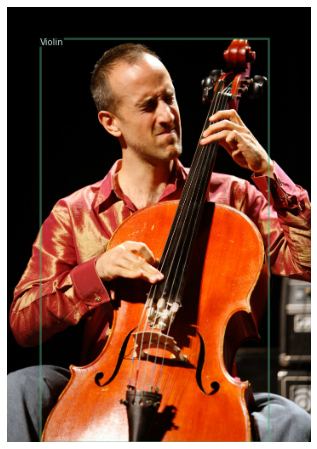

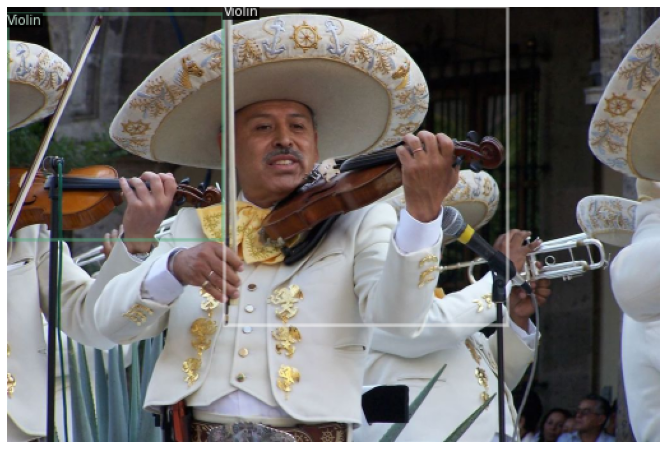

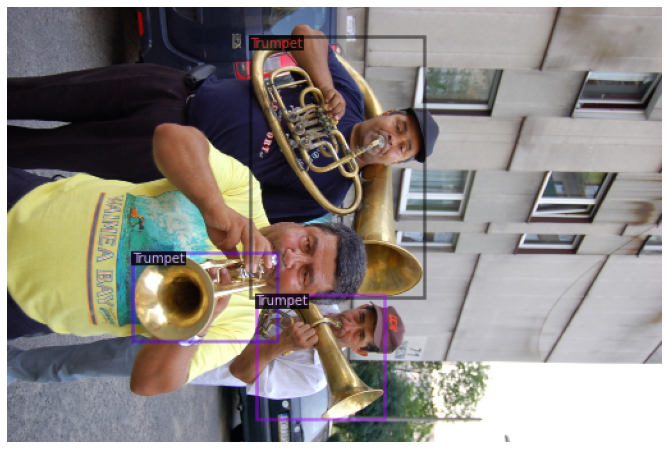

In [10]:
for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=detectron_metadata, scale=0.5)
    out = visualizer.draw_dataset_dict(d)
    cv2_imshow(out.get_image()[:, :, ::-1]);

## 3. Train

In [ ]:
models = [
    "COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml",
    "COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml",
    "COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml", # best
    "COCO-Detection/retinanet_R_50_FPN_3x.yaml",
    "COCO-Detection/retinanet_R_101_FPN_3x.yaml",
]

### Train

In [21]:
run_name = 'exp1'
!rm -rf $run_name

In [22]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")
cfg.DATASETS.TRAIN = ("musical_instruments_train",)
cfg.DATASETS.TEST = ("musical_instruments_validation",)

# Training hyperparameters
cfg.SOLVER.IMS_PER_BATCH = 4
cfg.SOLVER.BASE_LR = 0.005 # 0.02 / (16 / 4)
cfg.SOLVER.MAX_ITER = 300
#cfg.SOLVER.WARMUP_ITERS = 1000
#cfg.SOLVER.STEPS = (6000, 9000)

cfg.DATALOADER.NUM_WORKERS = 6
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
cfg.MODEL.ROI_HEADS.NUM_CLASSES = len(target_classes)
# cfg.MODEL.RETINANET.NUM_CLASSES = len(target_classes)
cfg.OUTPUT_DIR = run_name

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[06/24 22:36:29 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

3367it [00:51, 64.85it/s]

[06/24 22:37:21 d2.data.build]: Removed 0 images with no usable annotations. 3367 images left.


[06/24 22:37:21 d2.data.common]: Serializing 3367 elements to byte tensors and concatenating them all ...
[06/24 22:37:22 d2.data.common]: Serialized dataset takes 1.43 MiB
[06/24 22:37:22 d2.data.detection_utils]: TransformGens used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[06/24 22:37:22 d2.data.build]: Using training sampler TrainingSampler


Unable to load 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (4, 1024) in the model!
Unable to load 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (4,) in the model!
Unable to load 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (12, 1024) in the model!
Unable to load 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (12,) in the model!


[06/24 22:37:22 d2.engine.train_loop]: Starting training from iteration 0
[06/24 22:37:28 d2.utils.events]:  eta: 0:01:26  iter: 19  total_loss: 1.766  loss_cls: 1.273  loss_box_reg: 0.468  loss_rpn_cls: 0.026  loss_rpn_loc: 0.013  time: 0.3013  data_time: 0.0288  lr: 0.000100  max_mem: 5123M
[06/24 22:37:35 d2.utils.events]:  eta: 0:01:21  iter: 39  total_loss: 1.064  loss_cls: 0.535  loss_box_reg: 0.475  loss_rpn_cls: 0.026  loss_rpn_loc: 0.009  time: 0.3085  data_time: 0.0107  lr: 0.000200  max_mem: 5123M
[06/24 22:37:41 d2.utils.events]:  eta: 0:01:14  iter: 59  total_loss: 1.067  loss_cls: 0.488  loss_box_reg: 0.552  loss_rpn_cls: 0.018  loss_rpn_loc: 0.011  time: 0.3077  data_time: 0.0099  lr: 0.000300  max_mem: 5123M
[06/24 22:37:47 d2.utils.events]:  eta: 0:01:08  iter: 79  total_loss: 0.987  loss_cls: 0.425  loss_box_reg: 0.505  loss_rpn_cls: 0.018  loss_rpn_loc: 0.016  time: 0.3079  data_time: 0.0104  lr: 0.000400  max_mem: 5123M
[06/24 22:37:53 d2.utils.events]:  eta: 0:01:0

162it [00:02, 67.87it/s]

[06/24 22:38:59 d2.data.common]: Serializing 162 elements to byte tensors and concatenating them all ...
[06/24 22:38:59 d2.data.common]: Serialized dataset takes 0.06 MiB
WARNING [06/24 22:38:59 d2.engine.defaults]: No evaluator found. Use `DefaultTrainer.test(evaluators=)`, or implement its `build_evaluator` method.
[06/24 22:38:59 d2.utils.events]:  eta: 0:00:00  iter: 299  total_loss: 0.620  loss_cls: 0.233  loss_box_reg: 0.373  loss_rpn_cls: 0.013  loss_rpn_loc: 0.011  time: 0.3146  data_time: 0.0098  lr: 0.001499  max_mem: 5123M
[06/24 22:39:00 d2.engine.hooks]: Overall training speed: 297 iterations in 0:01:33 (0.3157 s / it)
[06/24 22:39:00 d2.engine.hooks]: Total training time: 0:01:36 (0:00:02 on hooks)


In [ ]:
# Look at training curves in tensorboard:
# !tensorboard --logdir .

## 4. Evaluation

In [24]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("musical_instruments_validation", cfg, False, output_dir=cfg.OUTPUT_DIR)
trainer.test(cfg=cfg,
             model=trainer.model,
             evaluators=evaluator)

162it [00:02, 67.93it/s]

[06/24 22:39:27 d2.data.common]: Serializing 162 elements to byte tensors and concatenating them all ...
[06/24 22:39:27 d2.data.common]: Serialized dataset takes 0.06 MiB
[06/24 22:39:27 d2.evaluation.evaluator]: Start inference on 162 images


[06/24 22:39:28 d2.evaluation.evaluator]: Inference done 11/162. 0.0400 s / img. ETA=0:00:06
[06/24 22:39:33 d2.evaluation.evaluator]: Inference done 135/162. 0.0388 s / img. ETA=0:00:01
[06/24 22:39:34 d2.evaluation.evaluator]: Total inference time: 0:00:06.434348 (0.040983 s / img per device, on 1 devices)
[06/24 22:39:34 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:06 (0.038974 s / img per device, on 1 devices)
[06/24 22:39:34 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[06/24 22:39:34 d2.evaluation.coco_evaluation]: Saving results to exp1/coco_instances_results.json
[06/24 22:39:34 d2.evaluation.coco_evaluation]: Evaluating predictions ...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.26s).
Accumulating evaluation results...
DONE (t=0.06s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.346
 Average 

OrderedDict([('bbox',
              {'AP': 34.64406366143317,
               'AP50': 68.2211489861689,
               'AP75': 28.584731682698074,
               'APs': 0.0,
               'APm': 10.519083457434968,
               'APl': 34.98754143683494,
               'AP-Piano': 45.782794057723194,
               'AP-Trumpet': 16.9077002998929,
               'AP-Violin': 41.241696626683414})])

#### Inference

In [29]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set the testing threshold for this model
cfg.DATASETS.TEST = ("camera_tripod_validation",)
predictor = DefaultPredictor(cfg)

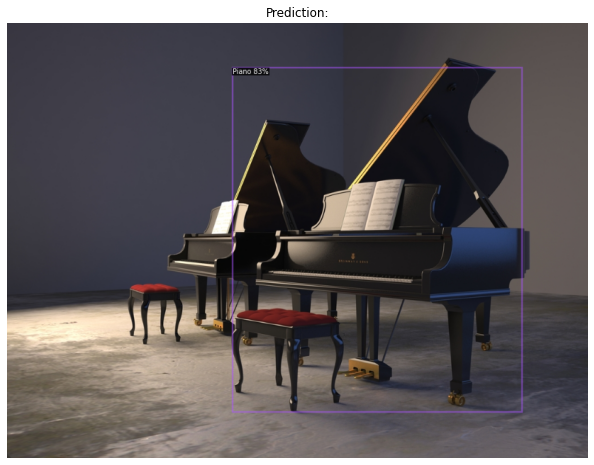

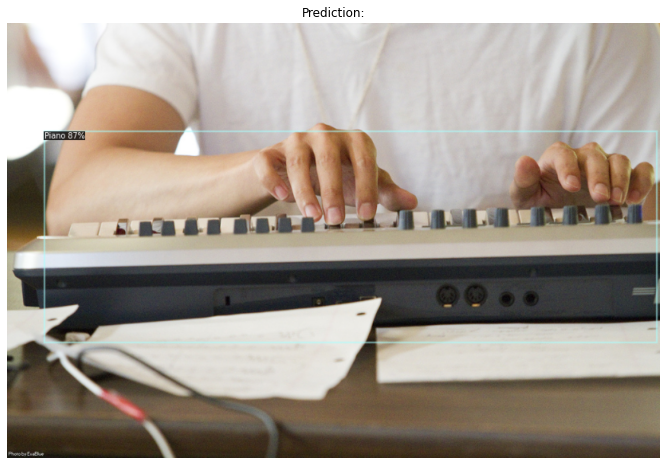

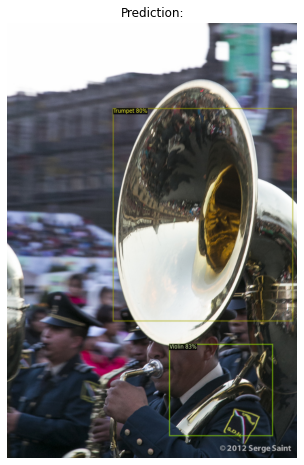

In [30]:
for d in random.sample(dataset_dicts, 3):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=detectron_metadata, 
                   scale=0.8)
    pred = v.draw_instance_predictions(outputs["instances"][:2].to("cpu"))
    cv2_imshow(pred.get_image()[:, :, ::-1])
    plt.title("Prediction:")